In [1]:
%load_ext autoreload
%autoreload 2

from t_nachine.optimization import Analyzer
import pandas as pd
from tqdm import tqdm

c:\users\abdel\desktop\workspace\just-trade-it\t_nachine\backtester\core\_plotting.py:43: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `core.set_bokeh_output(notebook=False)`.
  warnings.warn(


Loading BokehJS ...

In [2]:
path = "logs/extreme_rsi.csv"
df = pd.read_csv(path)

In [3]:
analyzer = Analyzer(df)

In [4]:
analyzer.win_rate

0.4444444444444444

In [5]:
analyzer.losing_streak_probability(n=4)

0.095

In [6]:
analyzer.winning_streak_probability(n=2)

0.198

In [7]:
analyzer.stats

Duration                       RiskToReward                       \
                 mean median min max    std         mean median    min    max   
WinningTrade                                                                    
False           8.800  4.000   1  31 12.498       -1.000 -1.000 -1.000 -1.000   
True            4.250  4.500   3   5  0.957        2.000  2.000  2.000  2.000   

                    
               std  
WinningTrade        
False        0.000  
True         0.000

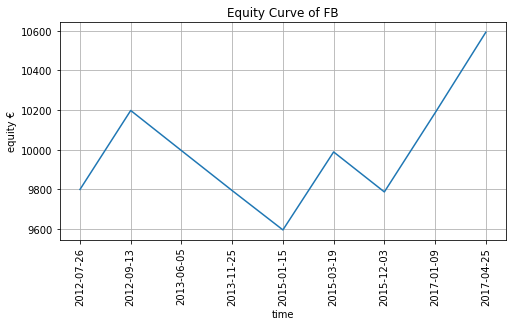

In [8]:
analyzer.plot_equity_curve()

In [30]:
600 / 10000

0.06

In [28]:
analyzer.first_entry_time, analyzer.last_entry_time

('2012-07-19', '2017-04-18')

In [29]:
analyzer.pct_return

1.0592361999999993

In [23]:
analyzer.backtest_results

,Size,EntryBar,ExitBar,OneR,SlPrice,TpPrice,EntryPrice,ExitPrice,MaxPnL,MaxNegativePnl,PnL,ReturnPct,EntryTime,ExitTime,Volume,Symbol,Duration,WinningTrade,RiskToReward
0,91,42,47,2.200,NaN,33.720,29.320,27.120,0.180,-1.310,-200.200,-0.075,2012-07-19,2012-07-26,13678536,fb,5,False,-1.000
1,158,76,81,1.260,17.520,21.300,18.780,21.300,2.380,-0.230,398.160,0.134,2012-09-06,2012-09-13,46055728,fb,5,True,2.000
2,128,258,261,1.580,NaN,27.970,24.810,23.230,0.140,-1.490,-202.240,-0.064,2013-05-31,2013-06-05,35912959,fb,3,False,-1.000
3,45,351,382,4.480,NaN,58.670,49.710,45.230,5.120,-3.990,-201.600,-0.090,2013-10-11,2013-11-25,58387406,fb,31,False,-1.000
4,79,664,668,2.510,NaN,83.300,78.280,75.770,0.340,-2.430,-198.290,-0.032,2015-01-09,2015-01-15,21151548,fb,4,False,-1.000
5,104,707,711,1.890,77.210,82.880,79.100,82.880,2.140,-1.740,393.120,0.048,2015-03-13,2015-03-19,18557200,fb,4,True,2.000
6,56,890,891,3.600,NaN,114.450,107.250,103.650,0.670,-1.460,-201.600,-0.034,2015-12-02,2015-12-03,24418950,fb,1,False,-1.000
7,61,1164,1167,3.266,114.674,124.472,117.940,124.472,5.940,-0.650,398.452,0.055,2017-01-04,2017-01-09,19270779,fb,3,True,2.000
8,84,1235,1240,2.420,139.230,146.490,141.650,146.490,4.024,-1.040,406.560,0.034,2017-04-18,2017-04-25,14901806,fb,5,True,2.000


In [11]:
def compute_cohots(price: float) -> int:
    
    if price <= 5:
        return 1
    
    if price <= 10:
        return 2
    
    if price <= 50:
        return 3
    
    if price <= 100:
        return 4
    
    if price <= 500:
        return 5
    
    if price <= 1000:
        return 6

    return 7

In [12]:
results = analyzer.backtest_results.copy()

In [13]:
def process_max_pnl(pnl, winning):
    if winning:
        return None
    
    return pnl

def process_max_negative_pnl(negative_pnl, winning):
    if winning:
        return negative_pnl
    return None

In [14]:
results['MaxPnL'] = results.apply(lambda x: process_max_pnl(x.MaxPnL, x.WinningTrade), axis=1)

In [15]:
results['MaxNegativePnl'] = results.apply(lambda x: process_max_negative_pnl(x.MaxNegativePnl, x.WinningTrade), axis=1)

In [16]:
results['normMaxPnL'] = results['MaxPnL'] / results['OneR']

In [17]:
results['normMaxNegativePnL'] = results['MaxNegativePnl'] / results['OneR']

In [18]:
results

,Size,EntryBar,ExitBar,OneR,SlPrice,TpPrice,EntryPrice,ExitPrice,MaxPnL,MaxNegativePnl,...,RSI,ADX,WILLIAMS,Volume,Symbol,Duration,WinningTrade,RiskToReward,normMaxPnL,normMaxNegativePnL
0,351.000,856.000,928.000,0.570,NaN,26.830,25.690,25.120,0.774,NaN,...,0.598,0.206,-0.061,86893.000,vno_l,72.000,False,-1.000,1.359,NaN
1,938.000,1645.000,1664.000,0.213,2.023,2.663,2.237,2.663,NaN,-0.117,...,0.530,0.087,-0.396,5754.000,asur,19.000,True,2.000,NaN,-0.547
2,1651.000,443.000,456.000,0.121,2.584,2.947,2.705,2.947,NaN,-0.019,...,0.581,0.159,-0.222,491177.000,omc,13.000,True,2.000,NaN,-0.153
3,1381.000,1243.000,1248.000,0.148,NaN,5.343,5.047,4.899,0.089,NaN,...,0.618,0.190,-0.226,980461.000,omc,5.000,False,-1.000,0.604,NaN
4,368.000,1571.000,1591.000,0.555,NaN,9.989,8.880,8.210,0.206,NaN,...,0.646,0.171,-0.082,593312.000,omc,20.000,False,-1.207,0.371,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29434,966.000,2048.000,2066.000,0.200,NaN,6.740,6.340,6.140,0.300,NaN,...,0.619,0.110,-0.038,33554.000,rdi,18.000,False,-1.000,1.500,NaN
29435,223.000,2305.000,2316.000,0.860,NaN,10.540,8.820,7.960,0.030,NaN,...,0.593,0.221,-0.103,22616.000,rdi,11.000,False,-1.000,0.035,NaN
29436,313.000,2607.000,2616.000,0.600,NaN,15.830,14.630,14.030,0.080,NaN,...,0.430,0.242,-0.789,29500.000,rdi,9.000,False,-1.000,0.133,NaN
29437,282.000,458.000,565.000,0.710,11.069,13.199,11.779,13.199,NaN,-0.378,...,0.542,0.254,-0.159,122837.000,fdus,107.000,True,2.000,NaN,-0.532


## Losing Trades

In [19]:
losses = results[~results.WinningTrade]

In [20]:
losses.normMaxPnL.describe(percentiles=[0.75, 0.8, 0.9])

count   18014.000
mean        0.648
std         0.531
min         0.000
50%         0.497
75%         0.983
80%         1.127
90%         1.487
max         5.159
Name: normMaxPnL, dtype: float64

In [21]:
## Less than 10 % of lossing reach at least 1.5R

In [22]:
losses[losses.normMaxPnL >= 2.0]

,Size,EntryBar,ExitBar,OneR,SlPrice,TpPrice,EntryPrice,ExitPrice,MaxPnL,MaxNegativePnl,...,RSI,ADX,WILLIAMS,Volume,Symbol,Duration,WinningTrade,RiskToReward,normMaxPnL,normMaxNegativePnL
200,232.000,5695.000,5697.000,0.765,NaN,40.021,38.491,37.726,3.226,NaN,...,0.596,0.196,-0.700,898463.000,ctas,2.000,False,-1.000,4.217,NaN
1421,582.000,911.000,912.000,0.344,NaN,10.170,9.483,8.956,0.769,NaN,...,0.591,0.226,-0.130,1228.000,dnbf,1.000,False,-1.532,2.238,NaN
6506,400.000,1807.000,1818.000,0.490,NaN,10.330,9.350,8.860,1.120,NaN,...,0.608,0.160,-0.267,37337.000,sim,11.000,False,-1.000,2.286,NaN
7386,700.000,1969.000,1969.000,0.300,6.000,6.900,6.300,6.240,0.696,NaN,...,0.678,0.170,-0.153,148448.000,abcd,0.000,False,-0.200,2.319,NaN
9263,215.000,419.000,424.000,0.960,NaN,22.086,20.166,19.206,2.704,NaN,...,0.619,0.267,-0.576,892485.000,pho,5.000,False,-1.000,2.817,NaN
10132,659.000,2645.000,2649.000,0.289,NaN,7.881,7.303,7.014,0.602,NaN,...,0.550,0.159,-0.352,651481.000,evc,4.000,False,-1.000,2.085,NaN
15433,244.000,137.000,143.000,0.821,NaN,42.237,40.595,39.774,1.659,NaN,...,0.595,0.196,-0.124,941170.000,ads,6.000,False,-1.000,2.021,NaN
18529,1089.000,1553.000,1571.000,0.180,NaN,3.390,3.030,2.850,0.380,NaN,...,0.446,0.264,-0.667,18223.000,edgw,18.000,False,-1.000,2.111,NaN
19742,120.000,5789.000,5804.000,1.702,NaN,49.595,46.191,44.489,4.180,NaN,...,0.449,0.189,-0.829,2131407.000,apa,15.000,False,-1.000,2.456,NaN
22515,961.000,3093.000,3136.000,0.202,NaN,11.352,10.948,10.746,0.439,NaN,...,0.648,0.141,-0.486,258590.000,jrs,43.000,False,-1.000,2.173,NaN


## Winning Trades

In [25]:
wins = results[results.WinningTrade]

In [28]:
abs(wins.normMaxNegativePnL).describe(percentiles=[0.75, 0.8, 0.9])

count   11425.000
mean        0.474
std         0.271
min         0.000
50%         0.445
75%         0.684
80%         0.739
90%         0.867
max         2.174
Name: normMaxNegativePnL, dtype: float64

## Corrr

In [30]:
results[['OneR', 'ATR']].corr()

,OneR,ATR
OneR,1.000,0.962
ATR,0.962,1.000


In [32]:
results[['ATR', 'WinningTrade']].corr()

,ATR,WinningTrade
ATR,1.000,-0.006
WinningTrade,-0.006,1.000


In [38]:
from t_nachine.constants import TRADES_ATTRIBUTES
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
corr = results[TRADES_ATTRIBUTES + ['WinningTrade']].corr()

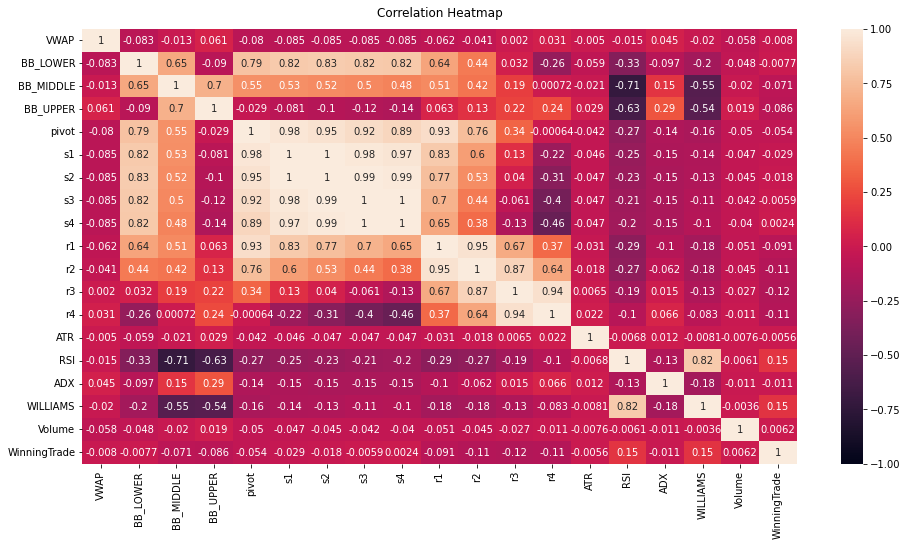

In [40]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);